In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from collections import defaultdict


class tcolors:
    GREEN = '\033[1;32;40m'
    ENDC = '\033[0m'
    
# 19 states (not including the ending state)
NUM_STATES = 19
START = 10
END_0 = 0
END_1 = 20


class RandomWalkEnv:

    def __init__(self, n, start=START, end=False, lr=0.1, gamma=1, debug=False):
        self.actions = ["left", "right"]
        self.state = start  # current state
        self.end = end
        self.n = n
        self.lr = lr
        self.gamma = gamma
        self.debug = debug
        # init q estimates
        self.Q_values = {}
        for i in range(NUM_STATES + 2):
            self.Q_values[i] = {}
            for a in self.actions:
                if i in [END_0, END_1]:
                    # explicitly set end state values
                    if i == END_0:
                        self.Q_values[i][a] = -1
                    else:
                        self.Q_values[i][a] = 1
                else:
                    self.Q_values[i][a] = 0

    def chooseAction(self):
        action = np.random.choice(self.actions)
        return action

    def takeAction(self, action):
        new_state = self.state
        if not self.end:
            if action == "left":
                new_state = self.state - 1
            elif action == "right":
                new_state = self.state + 1
            else:
                raise NotImplementedError

            if new_state in [END_0, END_1]:
                self.end = True
        self.state = new_state
        return self.state

    def giveReward(self):
        if self.state == END_0:
            return -1
        if self.state == END_1:
            return 1
        # other states
        return 0

    def reset(self):
        self.state = START
        self.end = False
        return self.state
        
    def step(self, action):
        return self.takeAction(action), self.giveReward(), self.end, None
    
    def render(self):
        curr_state_str = ' '.join(map(str, list(range(END_0, self.state))))
        curr_state_str += f"{tcolors.GREEN} {self.state} {tcolors.ENDC}"
        curr_state_str += ' '.join(map(str, list(range(self.state+1, END_1+1))))
        print(curr_state_str)
env = RandomWalkEnv(n=3)
done = False
while True:
    action = env.chooseAction()
    next_state, reward, done, info = env.step(action)
#     env.render()
    if done:
        break

In [2]:
np.random.randint(2)

1

In [3]:
def get_epsilon_greedy_action(Q, state, eps):
    nA = len(Q[state])
    if np.random.random() > eps:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(nA)
    return action 

In [4]:
def plot_metrics(scores, steps):
    # sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    data = pd.DataFrame({'scores':scores, 'steps':steps})
    data = data.rolling(100).mean()
    data.index = pd.Series(range(len(scores)), name='episodes')
    
    sns.lineplot(data=data['scores'], color='green', ax=ax[0], label='scores')
    sns.lineplot(data=data['steps'], color='orange', ax=ax[1], label='steps')
    

In [5]:
def plot_values(V):
        # reshape the state-value function
        V = np.reshape(V, (1, 21))
        # plot the state-value function
        fig = plt.figure(figsize=(21,5))
        ax = fig.add_subplot(111)
        im = ax.imshow(V, cmap='cool')
        for (j,i),label in np.ndenumerate(V):
            ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
        plt.title('State-Value Function')
        plt.show()

In [6]:
def semi_sarsa_n(env, num_episodes, n, alpha, gamma=1.0):
    
    nA = len(env.actions)
    
    # Initialize Q 
    Q = defaultdict(lambda : np.zeros(nA))
    
    # Uncomment to help value function converge faster
    # Set action value for terminal states
    Q[END_0] = -1 * np.ones(nA)
    Q[END_1] = np.ones(nA)
    
    # Initialize epsilon
    eps_i = 1
    
    # Initialize performance metrics
    ep_scores = []
    ep_steps = []
        
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # metric
        score, step = 0, 0
        
        # state_0
        state = env.reset()

        # action_0
        # eps_i = 1/i_episode
        action = get_epsilon_greedy_action(Q, state, eps_i)
        
        # storage for state_t+1, reward_t+1. action_t+1
        state_list, reward_list, action_list = [state], [action], [0]

        # T 
        T = np.inf

        # t <- 0
        for t in itertools.count():
            # when t < T:
            if t < T:
                # Take action_t 
                next_state, reward, done, info = env.step(env.actions[action])

                # store state_t+1 reward_t+1
                state_list.append(next_state)
                reward_list.append(reward)
                
                # update performance metric
                score += reward
                step += 1

                # if done :: set T <- t+1 
                if done:
                    T = t+1

                # else :: take next action
                else:
                    next_action = get_epsilon_greedy_action(Q, next_state, eps_i)
                    action_list.append(next_action)

            # calc update time -> tau
            tau = t - n + 1

            # if tau updatable ::
            if tau >= 0:

                # Calc G 
                G = 0
                start = tau + 1
                end = min(tau+n, T)
                
                for i in range(start, end+1):
                    G += math.pow(gamma, i-tau-1)*reward_list[i]

                # when tau+n < T, update G
                if tau + n < T:
                    state_tau_n, action_tau_n = state_list[tau + n], action_list[tau+n]
                    G += math.pow(gamma, n) * Q[state_tau_n][action_tau_n]
                    
                # update Q
                state_tau, action_tau = state_list[tau], action_list[tau]
                Q[state_tau][action_tau] += alpha * (G - Q[state_tau][action_tau])

            # break when tau = T - 1
            if tau == T - 1:
                break
                
            # t <- t + 1
            state = next_state
            action = next_action
            
        ep_scores.append(score)
        ep_steps.append(step)
        
    # Visualize performance
    plot_metrics(ep_scores, ep_steps)
    return Q

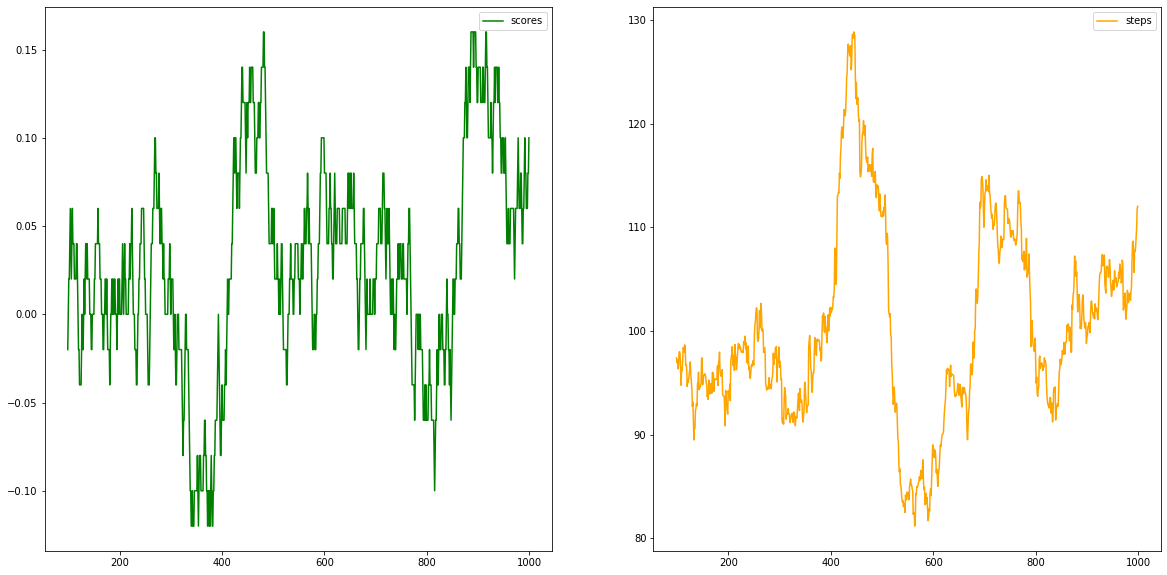

In [7]:
Q_semi_sarsa_n = semi_sarsa_n(env, 1000, 3, 0.01)


Estimated Optimal Policy (LEFT = 0, RIGHT = 1, N/A = -1):
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


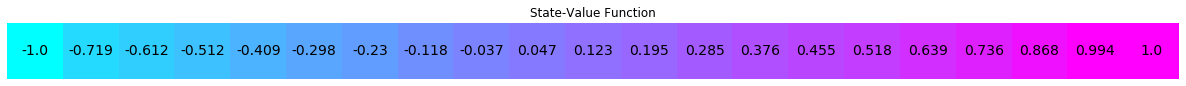

In [8]:
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_semi_sarsa_n[key]) if key in Q_semi_sarsa_n else -1 for key in np.arange(21)])
print("\nEstimated Optimal Policy (LEFT = 0, RIGHT = 1, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_semi_sarsa_n = ([np.max(Q_semi_sarsa_n[key]) if key in Q_semi_sarsa_n else 0 for key in np.arange(21)])
plot_values(V_semi_sarsa_n)